In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras import layers, optimizers, metrics


In [ ]:
# Define the Physics-Informed Neural Network (PINN) which integrates the Euler equation in the loss function
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = layers.Dense(50, activation="tanh")  # First dense layer with 50 neurons and tanh activation
        self.dense2 = layers.Dense(50, activation="tanh")  # Second dense layer
        self.outputs = layers.Dense(3)  # Output layer that predicts velocity, pressure, and density

    def call(self, inputs, training=False):
        x = self.dense1(inputs)  # Pass inputs through the first dense layer
        x = self.dense2(x)       # Pass through the second dense layer
        return self.outputs(x)   # Output the predictions

    def Euler_loss(self, predictions, inputs):
        # Loss function integrating Euler's equations
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(inputs)
            preds = self.call(inputs)
            v, p, rho = preds[:, 0], preds[:, 1], preds[:, 2]

        dv_dx = tape.gradient(v, inputs)[..., 1]
        dp_dx = tape.gradient(p, inputs)[..., 1]

        loss = tf.reduce_mean((dv_dx + v * dp_dx) ** 2)
        return loss

    def train_step(self, data):
        inputs, labels = data

        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.Euler_loss(predictions, inputs)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {'loss': loss}


In [ ]:
# Function to generate simulated data for training the PINN
def generate_data():
    t = np.linspace(0, 1, 100)  # Time coordinates
    x = np.linspace(0, 10, 100)  # Spatial coordinates
    T, X = np.meshgrid(t, x)
    inputs = np.vstack([T.ravel(), X.ravel()]).T
    velocities = np.sin(T.ravel()) * np.cos(X.ravel())
    pressures = np.cos(T.ravel()) * np.sin(X.ravel())
    densities = np.sin(T.ravel()) + np.cos(X.ravel())
    labels = np.vstack([velocities, pressures, densities]).T
    return inputs, labels

inputs, labels = generate_data()
inputs_tensor = tf.convert_to_tensor(inputs, dtype=tf.float32)
labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)


In [ ]:
# Initialize the PINN model and compile it with the Adam optimizer
model = PINN()
model.compile(optimizer=optimizers.Adam(learning_rate=0.01))

# Train the model
for epoch in range(1000):
    loss_value = model.train_step((inputs_tensor, labels_tensor))['loss']
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss_value.numpy()}')


Epoch 0, Loss: 0.00028822821332141757
Epoch 100, Loss: 2.7711478196579264e-06
Epoch 200, Loss: 5.246138243819587e-07
Epoch 300, Loss: 2.1590327037301904e-07
Epoch 400, Loss: 1.1666959665035392e-07
Epoch 500, Loss: 7.937465795748722e-08
Epoch 600, Loss: 6.009288000541346e-08
Epoch 700, Loss: 4.74171457653938e-08
Epoch 800, Loss: 3.8090789189482166e-08
Epoch 900, Loss: 3.095007627962332e-08


In [ ]:
# Predict using the trained model and calculate MSE for velocity, pressure, and density
predictions = model(inputs_tensor)
mse = metrics.MeanSquaredError()
mse_velocity = mse(predictions[:, 0], labels_tensor[:, 0])
mse_pressure = mse(predictions[:, 1], labels_tensor[:, 1])
mse_density = mse(predictions[:, 2], labels_tensor[:, 2])

print("MSE for Velocity:", mse_velocity.numpy())
print("MSE for Pressure:", mse_pressure.numpy())
print("MSE for Density:", mse_density.numpy())


MSE for Velocity: 0.1505715
MSE for Pressure: 2.8673275
MSE for Density: 2.158191


Fluent results file not found, generating dummy data for demonstration.


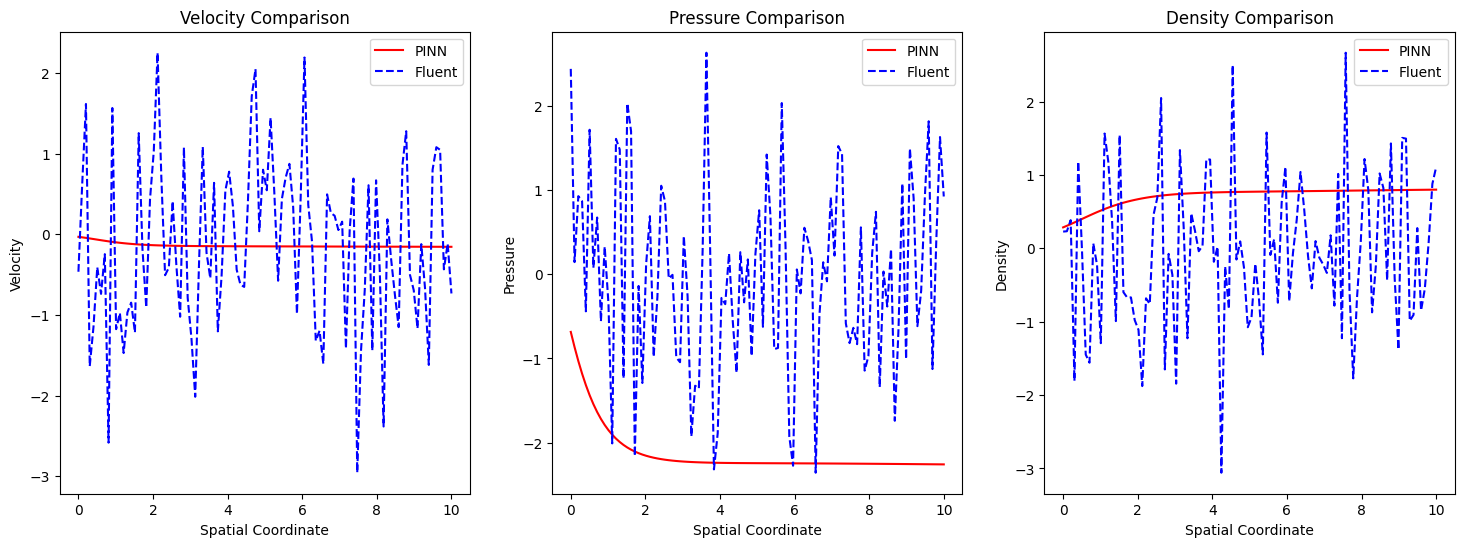

In [ ]:
# Check if Fluent results file exists, if not, create dummy data for demonstration
if os.path.exists('fluent_results.npy'):
    fluent_data = np.load('fluent_results.npy')
else:
    print("Fluent results file not found, generating dummy data for demonstration.")
    fluent_data = np.random.normal(size=predictions.shape)  # Mock data simulating Fluent results

# Compare results and plot
comparison_indices = np.linspace(0, len(inputs) - 1, num=100, dtype=int)  # Sample points for comparison
pin_predictions = predictions.numpy()[comparison_indices]
fluent_predictions = fluent_data[comparison_indices]

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(inputs_tensor.numpy()[comparison_indices, 1], pin_predictions[:, 0], 'r-', label='PINN')
plt.plot(inputs_tensor.numpy()[comparison_indices, 1], fluent_predictions[:, 0], 'b--', label='Fluent')
plt.title("Velocity Comparison")
plt.xlabel("Spatial Coordinate")
plt.ylabel("Velocity")
plt.legend()

plt.subplot(132)
plt.plot(inputs_tensor.numpy()[comparison_indices, 1], pin_predictions[:, 1], 'r-', label='PINN')
plt.plot(inputs_tensor.numpy()[comparison_indices, 1], fluent_predictions[:, 1], 'b--', label='Fluent')
plt.title("Pressure Comparison")
plt.xlabel("Spatial Coordinate")
plt.ylabel("Pressure")
plt.legend()

plt.subplot(133)
plt.plot(inputs_tensor.numpy()[comparison_indices, 1], pin_predictions[:, 2], 'r-', label='PINN')
plt.plot(inputs_tensor.numpy()[comparison_indices, 1], fluent_predictions[:, 2], 'b--', label='Fluent')
plt.title("Density Comparison")
plt.xlabel("Spatial Coordinate")
plt.ylabel("Density")
plt.legend()

plt.show()
